# Computer Networks Computer Assignment 2
## Arman Rostami, Parsa Ghorbani

### Initialization

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
SIMULATION_COUNT = 10
TCL_FILENAME = "congestion.tcl"
OUTPUT_ENDING = ".csv"
CWND_DATA_NAME = "cwnd"
GOODPUT_DATA_NAME = "goodput"
DROP_DATA_NAME = "drop"
RTT_DATA_NAME = "rtt"

In [3]:
plt.rcParams["figure.figsize"] = (14, 5) 

### Simulator

In [4]:
class Simulator:
    def __init__(self, congestion_algorithm):
        self.congestion_algorithm = congestion_algorithm
        self.data = {}

In [5]:
def train(self):
    for i in range(0, SIMULATION_COUNT):
        os.system("ns " + TCL_FILENAME + " " + self.congestion_algorithm)
        self.update_data(i, CWND_DATA_NAME)
        self.update_data(i, GOODPUT_DATA_NAME)
        self.update_data(i, RTT_DATA_NAME)
        
Simulator.train = train

In [6]:
def plot_diagram(self, data_1, data_2):
    plt.plot(data_1, "b", label="Top flow")
    plt.plot(data_2, "r", label="Bottom flow")
    plt.xlabel("time")
    plt.ylabel(data_1.name)
    plt.legend()

Simulator.plot_diagram = plot_diagram

In [7]:
def get_dict_key(self, data_name, index):
    return data_name + "_" + str(index)

Simulator.get_dict_key = get_dict_key

In [8]:
def update_data(self, simulation_index, data_name):
    new_data_1 = pd.read_csv(data_name + "1" + OUTPUT_ENDING)
    new_data_2 = pd.read_csv(data_name + "2" + OUTPUT_ENDING)
        
    data_dict_key_1 = self.get_dict_key(data_name, 1)
    data_dict_key_2 = self.get_dict_key(data_name, 2)
    
    if simulation_index == 0:
        self.data[data_dict_key_1] = new_data_1[data_name]
        self.data[data_dict_key_2] = new_data_2[data_name]
    else:
        self.data[data_dict_key_1] += new_data_1[data_name]
        self.data[data_dict_key_2] += new_data_2[data_name]
        
    if simulation_index == SIMULATION_COUNT - 1:
        self.data[data_dict_key_1] /= SIMULATION_COUNT
        self.data[data_dict_key_2] /= SIMULATION_COUNT
    
Simulator.update_data = update_data

In [9]:
def plot_data(self, data_name):
    data_1 = self.data[self.get_dict_key(data_name, 1)]
    data_2 = self.data[self.get_dict_key(data_name, 2)]
    self.plot_diagram(data_1, data_2)
    
Simulator.plot_data = plot_data

### Train Simulators

In [10]:
new_reno_simulator = Simulator("Newreno")
new_reno_simulator.train()

In [11]:
tahoe_simulator = Simulator("Tahoe")
tahoe_simulator.train()

In [12]:
vegas_simulator = Simulator("Vegas")
vegas_simulator.train()

### CWND

#### Newreno

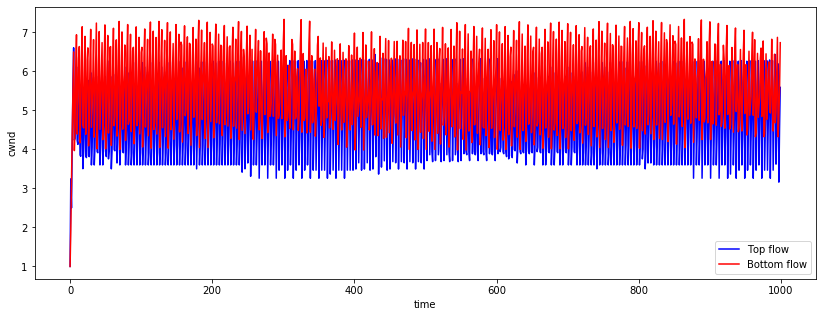

In [13]:
new_reno_simulator.plot_data(CWND_DATA_NAME)

#### Tahoe

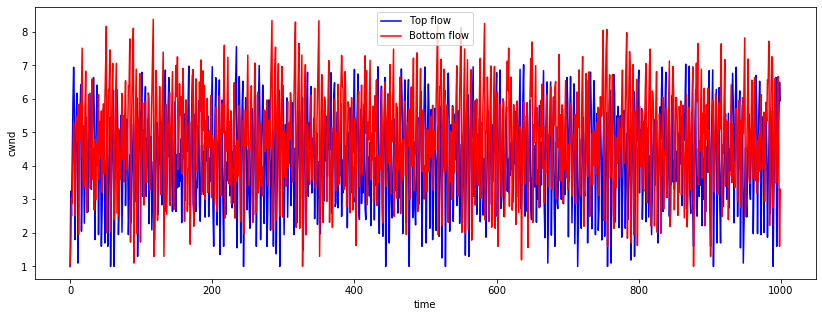

In [14]:
tahoe_simulator.plot_data(CWND_DATA_NAME)

#### Vegas

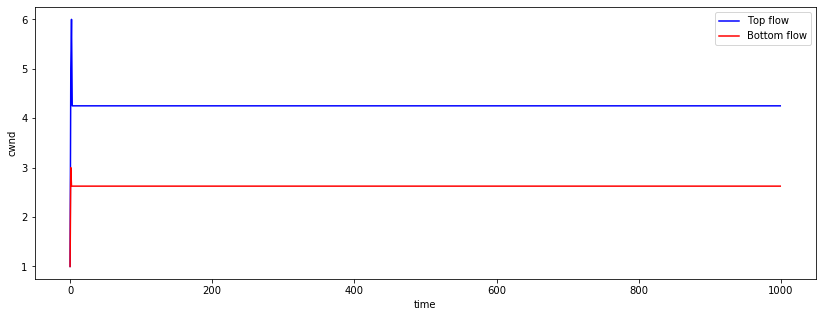

In [15]:
vegas_simulator.plot_data(CWND_DATA_NAME)

### Goodput

#### Newreno

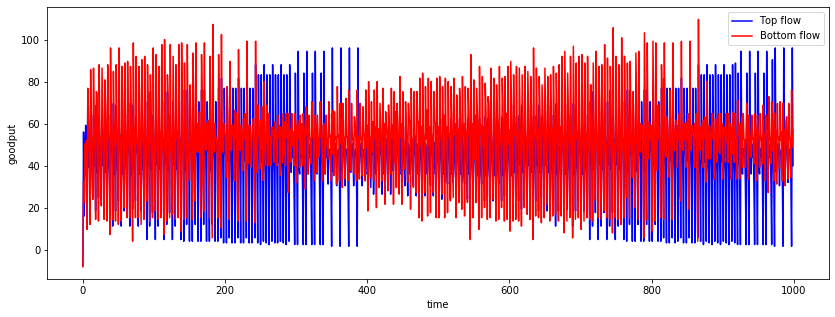

In [16]:
new_reno_simulator.plot_data(GOODPUT_DATA_NAME)

#### Tahoe

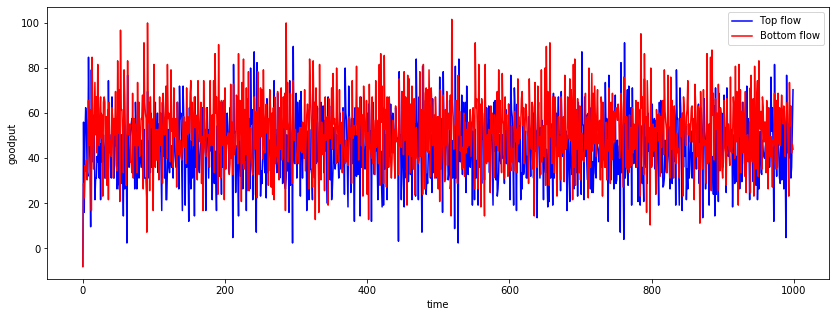

In [17]:
tahoe_simulator.plot_data(GOODPUT_DATA_NAME)

#### Vegas

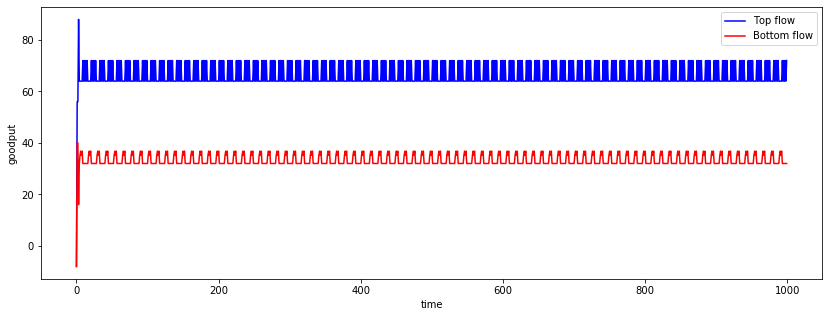

In [18]:
vegas_simulator.plot_data(GOODPUT_DATA_NAME)

### RTT

#### Newreno

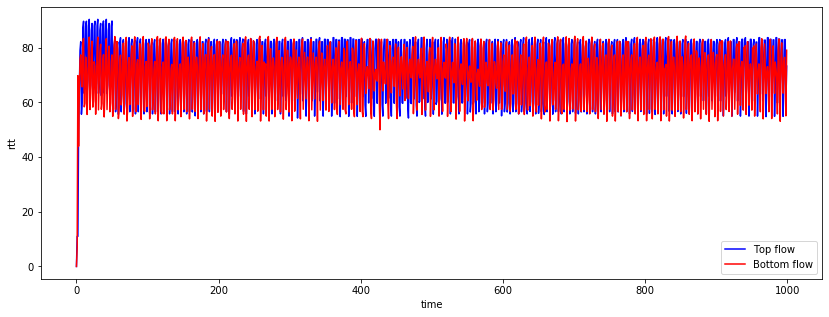

In [19]:
new_reno_simulator.plot_data(RTT_DATA_NAME)

#### Tahoe

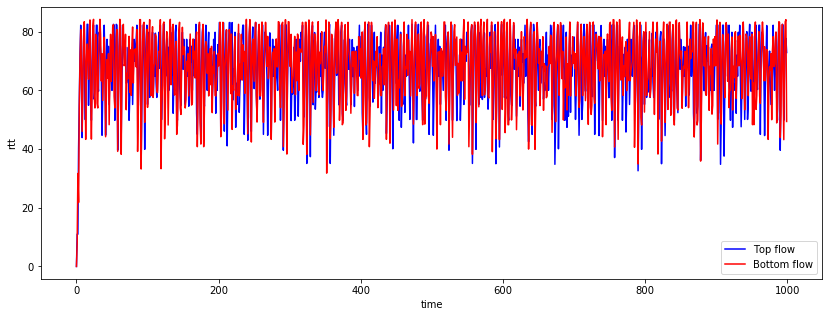

In [20]:
tahoe_simulator.plot_data(RTT_DATA_NAME)

#### Vegas

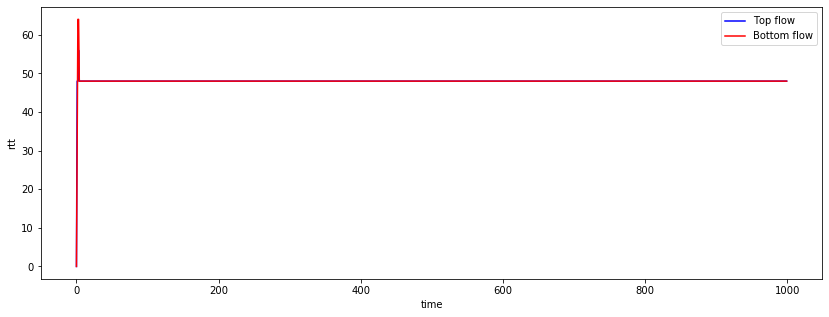

In [21]:
vegas_simulator.plot_data(RTT_DATA_NAME)